In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Data transformation

In [2]:
## Reading the csv file and creating the data and label dataframe

df = pd.read_csv('full_dataframe.csv')
X, y = df.drop(['winningSide', 'mapName', 'tick'], axis=1), df['winningSide']

In [3]:
## Transforming the labels into 1 for CT and 0 for T
mapping = {'T': 0, 'CT': 1}
y = y.map(mapping)

In [4]:
## Creating a train test split for the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
from sklearn.preprocessing import MinMaxScaler
## Scaling the data (min 0, max 1)

scaler = MinMaxScaler((0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### First model training and hyperparameters optimization

In [243]:
## Creating the keras model with callbacks to find the optimal learning rate
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## Compiling the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
    )

## Creating the callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* 10**(epoch/15))

## Fitting the model
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=50, callbacks=[lr_scheduler, ])


Epoch 1/50
756/756 [==============================] - 3s 3ms/step - loss: 0.6944 - accuracy: 0.5211 - lr: 1.0000e-06
Epoch 2/50
756/756 [==============================] - 2s 3ms/step - loss: 0.6844 - accuracy: 0.6031 - lr: 1.1659e-06
Epoch 3/50
756/756 [==============================] - 2s 3ms/step - loss: 0.6739 - accuracy: 0.6748 - lr: 1.3594e-06
Epoch 4/50
756/756 [==============================] - 2s 3ms/step - loss: 0.6628 - accuracy: 0.7035 - lr: 1.5849e-06
Epoch 5/50
756/756 [==============================] - 2s 3ms/step - loss: 0.6513 - accuracy: 0.7180 - lr: 1.8478e-06
Epoch 6/50
756/756 [==============================] - 2s 3ms/step - loss: 0.6392 - accuracy: 0.7312 - lr: 2.1544e-06
Epoch 7/50
756/756 [==============================] - 2s 3ms/step - loss: 0.6257 - accuracy: 0.7439 - lr: 2.5119e-06
Epoch 8/50
756/756 [==============================] - 2s 3ms/step - loss: 0.6104 - accuracy: 0.7496 - lr: 2.9286e-06
Epoch 9/50
756/756 [==============================] - 2s 3ms/ste

<Axes: xlabel='epochs'>

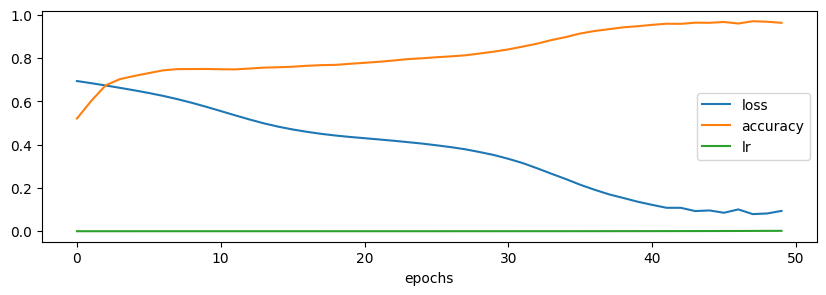

In [244]:
## Plotting model history

pd.DataFrame(history.history).plot(figsize=(10,3), xlabel='epochs')

0.00018478498

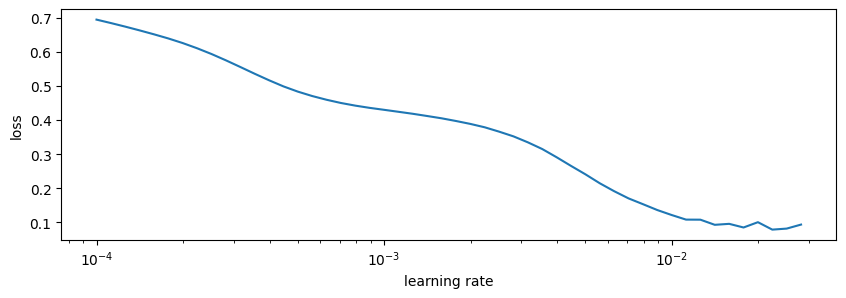

In [261]:
# Ploting the learning rate X loss to find the optimal learning rate (greatest loss inclination)
learning_rate = 1e-4* 10**(tf.range(50)/20)
plt.figure(figsize=(10,3))
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.semilogx(learning_rate, history.history['loss'])
history.history['lr'][34]

## Optimized learning rate = 0.0002

### Optimized new model

In [22]:
## Creating new model with the optimized hyperparameters

optimized_model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimized_model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    metrics=["accuracy"]
    )

optimized_history = optimized_model.fit(X_train_scaled, y_train, batch_size=32, epochs=100)


Epoch 1/100
756/756 [==============================] - 3s 3ms/step - loss: 0.4746 - accuracy: 0.7632
Epoch 2/100
756/756 [==============================] - 2s 3ms/step - loss: 0.3928 - accuracy: 0.8015
Epoch 3/100
250/756 [========>.....................] - ETA: 1s - loss: 0.3613 - accuracy: 0.8204

KeyboardInterrupt: 

In [21]:
predicted = optimized_model.predict(X_test_scaled)
optimized_model.evaluate(X_test_scaled, y_test)

a = np.c_[tf.round(predicted), y_test]

NameError: name 'optimized_model' is not defined

In [41]:
## Saving optimized model

optimized_model.save('modelo0_997')

INFO:tensorflow:Assets written to: modelo0_997\assets


### Predicting a game from outside of the traning data

In [23]:
from sklearn.preprocessing import MinMaxScaler

## Loading saved model after restart

model = tf.keras.models.load_model('modelo0_997')
model.evaluate(X_test_scaled, y_test)

## Loading the cleaned data from `data_modeling.ipynb`

predict_df = pd.read_csv('vita-vs-heroic-dataframe.csv')
new_X, new_y = predict_df.drop(['winningSide', 'mapName', 'tick'], axis=1), predict_df['winningSide']

## Transforming the labels into 1 for CT and 0 for T
mapping = {'T': 0, 'CT': 1}
new_y = new_y.map(mapping)

## Scaling new_X value
scaler = MinMaxScaler((0, 1))
new_X_scaled = scaler.fit_transform(new_X)

189/189 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9993


In [7]:
## Predicting the results and evaluating the model with outside data
new_predicted = model.predict(new_X_scaled)
model.evaluate(new_X_scaled, new_y)


73/73 [==============================] - 0s 2ms/step - loss: 2.3613 - accuracy: 0.8267


[2.361257553100586, 0.826724112033844]

##### Transforming values to CT or T for data visualization

In [24]:
## Transforming the predicted value to CT or T
rounded_predicted = pd.DataFrame(tf.round(new_predicted), columns=['predicted'])
rev_mapping = {v: k for k,v in mapping.items()}
map_predicted = rounded_predicted['predicted'].map(rev_mapping)

## Transforming the y labels to CT or T
labels = new_y.map(rev_mapping)


dataframe =  pd.concat([new_X, map_predicted, labels], axis=1)


In [25]:
dataframe[dataframe['roundNum'] == 3]

,roundNum,seconds,ct_hp,ct_armor,ct_flashGrenades,ct_smokeGrenades,ct_heGrenades,ct_fireGrenades,ct_isAlive,ct_isDefusing,...,t_equipmentValueRoundStart,t_cash,t_cashSpendThisRound,t_hasHelmet,t_hasDefuse,t_hasBomb,t_Score,ct_Score,predicted,winningSide
114,3,0.773438,500,495,6,4,4,4,5,0,...,1000,300,7500,1,0,0,1,1,T,CT
115,3,1.773438,500,495,6,4,4,4,5,0,...,1000,300,7500,1,0,0,1,1,T,CT
116,3,2.773438,500,495,6,4,4,4,5,0,...,1000,300,7500,1,0,0,1,1,T,CT
117,3,3.773438,500,495,6,4,4,4,5,0,...,1000,300,7500,1,0,0,1,1,T,CT
118,3,4.773438,500,495,6,4,4,4,5,0,...,1000,300,7500,1,0,0,1,1,T,CT
119,3,5.773438,500,495,6,4,4,3,5,0,...,1000,300,7500,1,0,0,1,1,T,CT
120,3,6.773438,500,495,5,4,4,3,5,0,...,1000,300,7500,1,0,0,1,1,T,CT
121,3,7.773438,500,495,5,4,4,3,5,0,...,1000,300,7500,1,0,0,1,1,T,CT
122,3,8.773438,500,495,5,4,3,3,5,0,...,1000,300,7500,1,0,0,1,1,T,CT
123,3,9.773438,500,495,5,4,3,3,5,0,...,1000,300,7500,1,0,0,1,1,T,CT


##### Plotting the confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(new_y, tf.round(new_predicted))

array([[ 735,  147],
       [ 255, 1183]], dtype=int64)

##### Creating a function to prettify the confusion matrix

In [63]:
## Based on SKlearn plot_confusion_metrics
import itertools

def plot_confusion_matrix(y_true, y_pred):
    figsize = (6,6)
    # Create confusion matrix
    cm = confusion_matrix(y_true, tf.round(y_pred))
    cm_norm = cm.astype('float') / cm.sum(axis=1) # Normalizing confusion matrix
    n_classes = cm.shape[0]

    # Prettify
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Create classes
    classes = False

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title='Confusion Matrix',
           xlabel ='Predicted Label',
           ylabel = 'True Label',
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)
    
    # Place x-labels on bottom
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    # Adjust labels sizes
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(12)

    # Set treshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
                 horizontalalignment='center',
                 color='white' if cm[i,j] > threshold else 'black',
                 size=12)




### Plotting the confusion matrix for evaluation

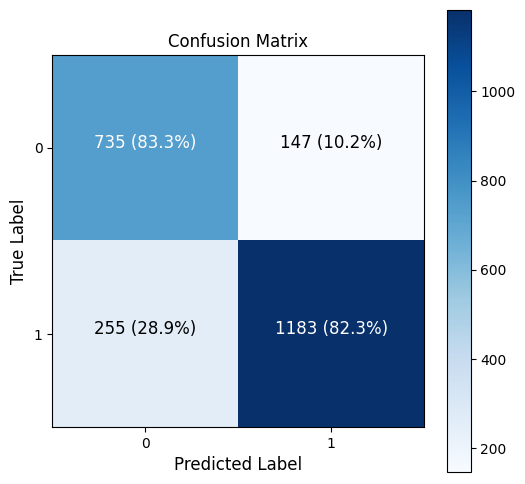

In [64]:
plot_confusion_matrix(new_y, tf.round(new_predicted))